## Importando Bibliotecas e Dependências

In [1]:
# Importação de bibliotecas externas necessárias
import sys
import os
sys.path.append(os.path.abspath("../..")) 

from deap import base, creator, tools, benchmarks
import deap.cma as cma

import copy
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import math
import time
import pandas as pd

# Importação de módulos personalizados
from Modules.Helpers import Helper
from Modules.Solvers import Solvers
from Modules.Plotters import Plotter
from Modules.Equations import Equation
from Modules.Models import *
from Modules.EvolutionModules import *

## Configuração do DEAP e do CMA-ES

In [2]:
np.random.seed(42)

In [3]:
#INICIALIZANDO MODELO
GRN5 = ModelWrapper.GRN5()

# Criação do tipo de indivíduo e toolbox
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("evaluate", Individual.cma_evaluate, model=GRN5)

# Inicializa estratégia CMA-ES
centroids = Individual.initialize_average_bounds(GRN5)
strategy = cma.Strategy(centroid=centroids, sigma=10, lambda_=int(4+(3*np.log(GRN5.IND_SIZE))))

toolbox.register("generate", strategy.generate, creator.Individual)
toolbox.register("update", strategy.update)

# Estatísticas e parâmetros do algoritmo
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda individual: individual.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

## Loop principal do CMA-ES

C:\Users\anabi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\integrate\_ivp\common.py:39: UserWarning: The following arguments have no effect for a chosen solver: `min_step`.
  warn("The following arguments have no effect for a chosen solver: {}."


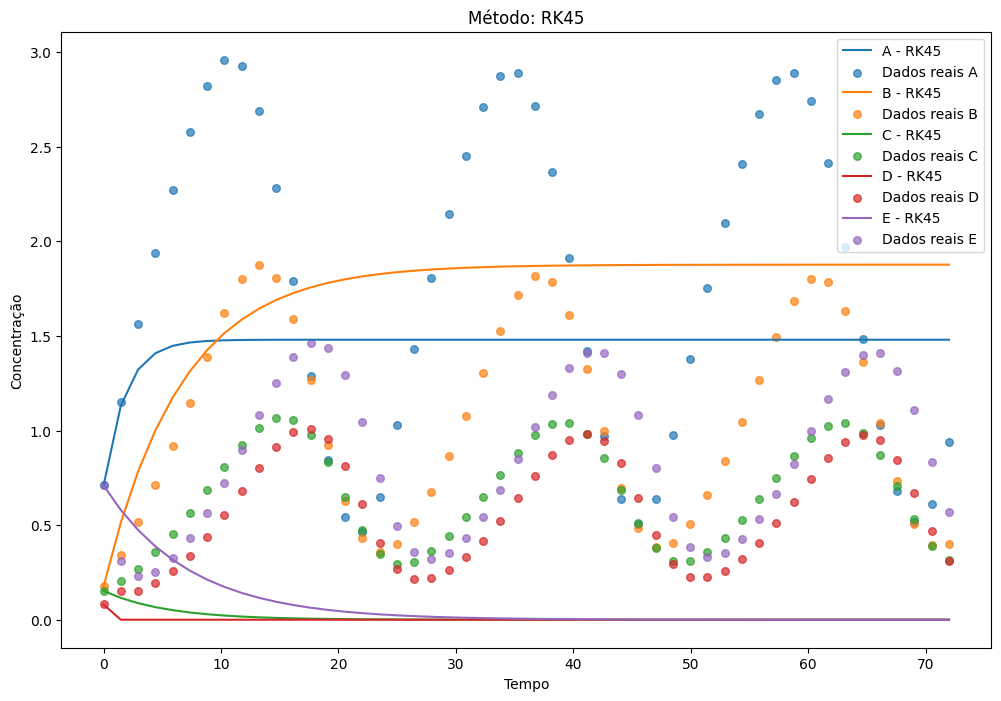

Sigma increased due to no improvement. New sigma: 1.5123260448571516, 'min': 7.4938906855164005, 'max': 13.078528065569849}}}


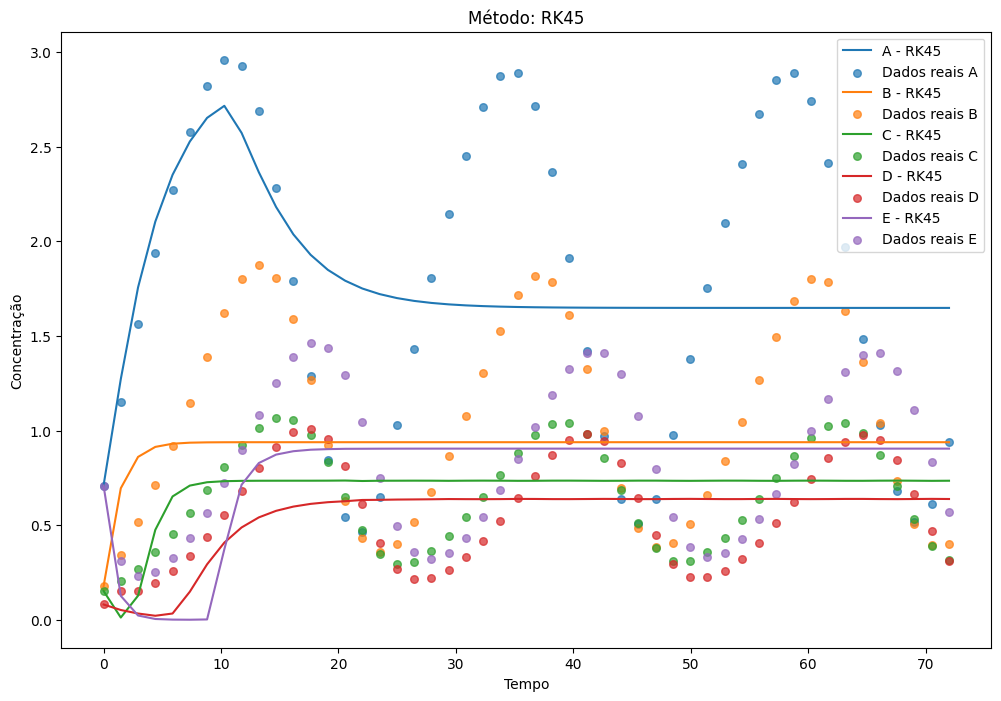

Sigma increased due to no improvement. New sigma: 2.3657608246267982, 'min': 7.861940106329958, 'max': 9.26259412389079}8}}
Sigma increased due to no improvement. New sigma: 5.3090502932475294, 'min': 8.034470009380135, 'max': 13.933325964235697}}
Sigma increased due to no improvement. New sigma: 5.195462325525144, 'min': 7.8659974544450275, 'max': 12.682392586406703}}}
Sigma increased due to no improvement. New sigma: 3.12303879672377216, 'min': 7.644244288171398, 'max': 8.205509800281202}}}
Sigma increased due to no improvement. New sigma: 6.0986298188649342, 'min': 7.537371264830798, 'max': 10.07347940522684}}}


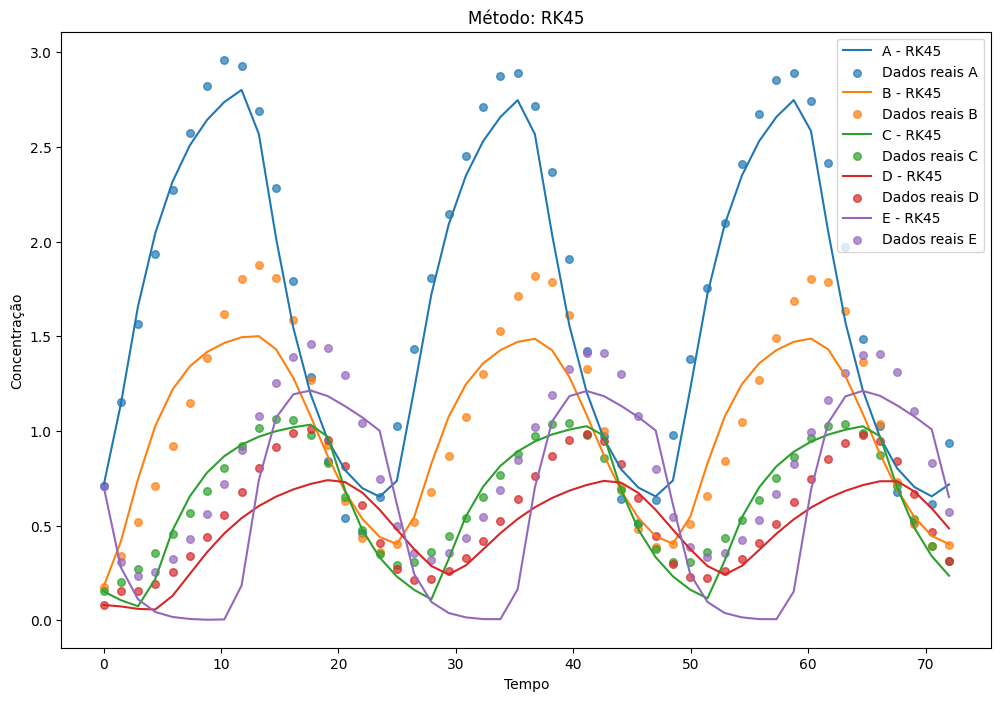

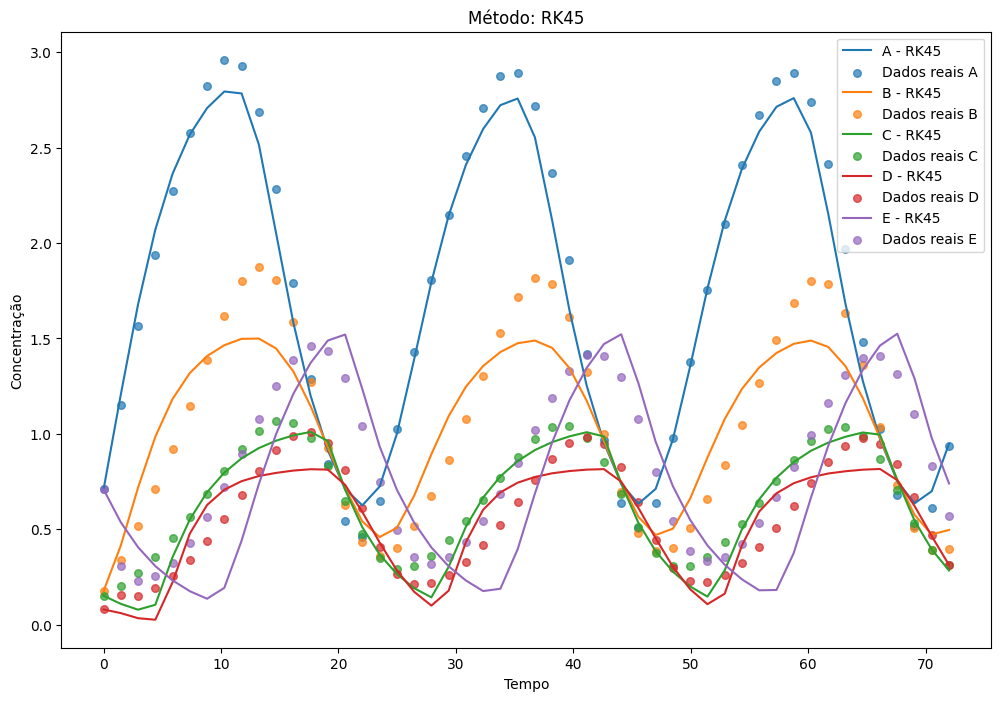

Sigma increased due to no improvement. New sigma: 1 0.0012998999285775237, 'min': 2.629676576595791, 'max': 2.63440655143961}}}}
Overflowon 1783: {'avg': 2.4345361177458495, 'std': 0.0006199280772863881, 'min': 2.4340373259305763, 'max': 2.4358592276798943}
Sigma increased due to no improvement. New sigma: 1.108704338608585e-05, 'min': 2.434009217551902, 'max': 2.434107947011065}325}}


In [ ]:
GENERATION_LIMIT = 5000
NO_IMPROVEMENT_LIMIT = 50
HARD_SIGMA_INCREASE_FACTOR = 10
TOLERANCE = 1E-4


population = toolbox.generate()
Individual.apply_bounds(population, model=GRN5)
best_fitness = None
no_improvement_counter = 0
best_individual = None

for gen in range(GENERATION_LIMIT):
    for i, ind in enumerate(population):
        ind.fitness.values = toolbox.evaluate(ind)

    record = stats.compile(population)

    current_best_fitness = min(ind.fitness.values[0] for ind in population)
    hof.update(population)

    if best_fitness is None or current_best_fitness < best_fitness - TOLERANCE:
        best_fitness = current_best_fitness
        no_improvement_counter = 0
        best_individual = hof[0]
    else:
        no_improvement_counter += 1

    if no_improvement_counter >= (NO_IMPROVEMENT_LIMIT + gen/100):
        
        strategy.sigma = min(max(strategy.sigma*HARD_SIGMA_INCREASE_FACTOR, 1), 15)
        print(f"Sigma increased due to no improvement. New sigma: {strategy.sigma}")
        no_improvement_counter = 0

    toolbox.update(population)

    print(f"Generation {gen}: {record}", end='\r')

    if gen % 500 == 0:
        best_ind = Individual.list_to_ind(best_individual, model=GRN5)
        Plotter.plot_ind(best_ind, comparison=False)

    population = toolbox.generate()
    Individual.apply_bounds(population, model=GRN5)

    # population[0][:] = super_ind  # e.g., injecting the best individual into the population
